In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
sys.path.insert(0,'../debugging')
from mvpose.data import shelf
from time import time

data_root = Settings['data_root']
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d
from mvpose.baseline.baseline import estimate
from openpose import OpenPose

seq1_zipname = 'player2sequence1.zip'
seq1_dir = 'Sequence 1'

peak_threshold = 0.08
pe = OpenPose(tmp=tmp, peak_threshold=peak_threshold)

# ====================================================
# Extractor Functions
# ====================================================
def extract_best(pos3d, Humans, alpha):
    """
        Extracts the best fitting human for the calculation
    """
    larms = 0
    uarms = 0
    ulegs = 0
    llegs = 0
    all_parts = 0
    
    for h in Humans:
        r = pcp.evaluate(pos3d, Humans[0], alpha)
        if all_parts < r.all_parts:
            larms = r.lower_arms
            uarms = r.upper_arms
            ulegs = r.upper_legs
            llegs = r.lower_legs
    
    return {
        "larms": larms,
        "uarms": uarms,
        "ulegs": ulegs,
        "llegs": llegs
    }

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
from mvpose.baseline.tracking import tracking
from time import time

Calib = []
poses_per_frame = []
Pos3d = []

_start = time()
#for frame in range(0, 214):
end_frame = 214
for frame in range(0, end_frame):
    Im, calib, pos2d, pos3d = kth.get(
        data_root, seq1_zipname, seq1_dir, frame, player=2)
    Calib.append(calib)
    Pos3d.append(pos3d)
    
    txt_add = str(peak_threshold)
    if 0.099 < peak_threshold < 0.101:
        txt_add = ''
    
    name = 'cvpr_kth_' + seq1_zipname + txt_add
    predictions = pe.predict(Im, name, frame)
    poses_per_frame.append(predictions)
_end = time()
print('elapsed', _end - _start)

elapsed 20.53778862953186


In [3]:
# print(track.get_by_frame(213))

# track.last_seen()

In [32]:
tracks = tracking(Calib, poses_per_frame,
                  epi_threshold=110,
                  scale_to_mm=1000,
                  max_distance_between_tracks=200,
                  distance_threshold=200,
                  correct_limb_size=False,
                  merge_distance=200)

track = tracks[0]

from mvpose.baseline.tracking import Track
track = Track.smoothing(track, sigma=5, interpolation_range=5)
# track = Track.smoothing(track, sigma=2.4, interpolation_range=5)

# for jid in range(18):
#     A = track.poses[0]
#     B = track_new.poses[0]
#     if A[jid] is not None and B[jid] is not None:
#         print('jid', jid)
#         print("\t", np.round(A[jid], 4))
#         print('\t', np.round(B[jid], 4))
    
alpha = 0.5

larms = []
uarms = []
llegs = []
ulegs = []

_start = time()
for frame in range(0, end_frame):
    
    pos3d = Pos3d[frame]
    pose = track.get_by_frame(frame)
    Humans = []
    if pose is not None:
        Humans.append(pose)
    
    Humans = kth.transform3d_from_mscoco(Humans)
    result = extract_best(pos3d, Humans, alpha)
    
    larms.append(result['larms'])
    uarms.append(result['uarms'])
    llegs.append(result['llegs'])
    ulegs.append(result['ulegs'])

_end = time()
print('elapsed', _end - _start)

n frames 214
elapsed 0.06657576560974121


In [5]:
# 0.03 --> 0.9024532710280373
# 0.05 --> 0.9024532710280373
# 0.08 --> 0.9036214953271028

In [33]:
print("upper arms:\t", np.mean(uarms))
print("lower arms:\t", np.mean(larms))
print("upper legs:\t", np.mean(ulegs))
print("lower legs:\t", np.mean(llegs))
print('avg:\t\t', np.mean([
    np.mean(uarms), np.mean(larms), np.mean(ulegs), np.mean(llegs)
]))

upper arms:	 1.0
lower arms:	 0.9789719626168224
upper legs:	 0.9626168224299065
lower legs:	 0.7967289719626168
avg:		 0.9345794392523364


In [7]:
# Smoothing, hm = 0.1
# upper arms:	 0.9906542056074766
# lower arms:	 0.9649532710280374
# upper legs:	 0.9649532710280374
# lower legs:	 0.8995327102803738
# avg:		 0.9550233644859814

# upper arms:	 0.9906542056074766
# lower arms:	 0.9672897196261683
# upper legs:	 0.9649532710280374
# lower legs:	 0.8995327102803738
# avg:		 0.955607476635514

5
6
8
9
10
14
16
31
32
39
97
164


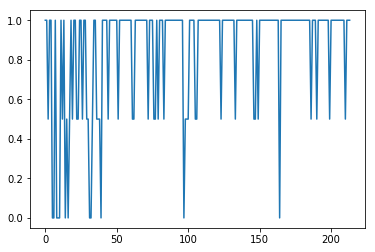

In [8]:
plt.plot(range(len(larms)), larms)

# print(np.argmin(llegs))
for frame, value in enumerate(larms):
    if value == 0:
        print(frame)

0.44388512925555307
0.5145600815358193
0.7007984704105183


<Figure size 1152x864 with 0 Axes>

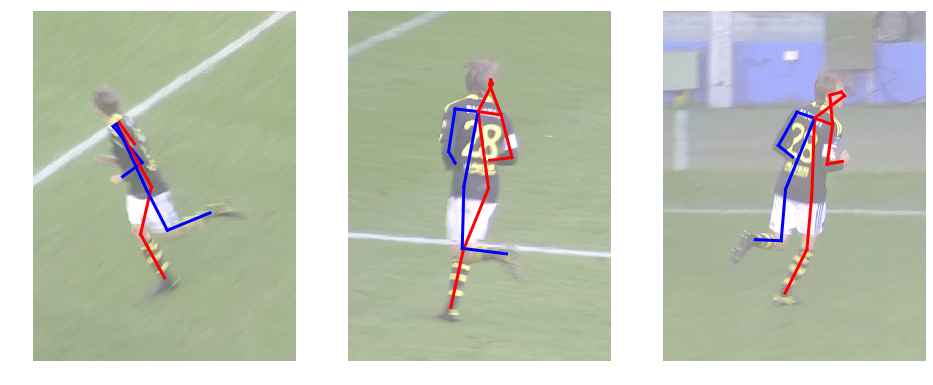

In [9]:
from mvpose.baseline.hypothesis import get_believe
FRAME = 0
# FRAME = 0

Im, calib, pos2d, pos3d = kth.get(data_root, seq1_zipname, seq1_dir, FRAME, player=2)

pos3d = Pos3d[FRAME]

predictions = poses_per_frame[FRAME]
Humans = predictions

fig = plt.figure(figsize=(16,12))

colors = ['blue', 'red', 'green']

fig = plt.figure(figsize=(16, 8))
for idx, (im, pred) in enumerate(zip(Im, predictions)):
    ax = fig.add_subplot(1, 3, idx+1); ax.axis('off')
    ax.imshow(im, alpha=0.6)
    
    for human in pred:
        draw_mscoco_human2d(ax, human[:, 0:2], color='red', lcolor='blue', linewidth=3)

for prs in predictions:
    for p in prs:
        print(get_believe(np.squeeze(p)))
        
plt.show()

FRAME 0
{'larms': 1.0, 'uarms': 1.0, 'ulegs': 1.0, 'llegs': 1.0}


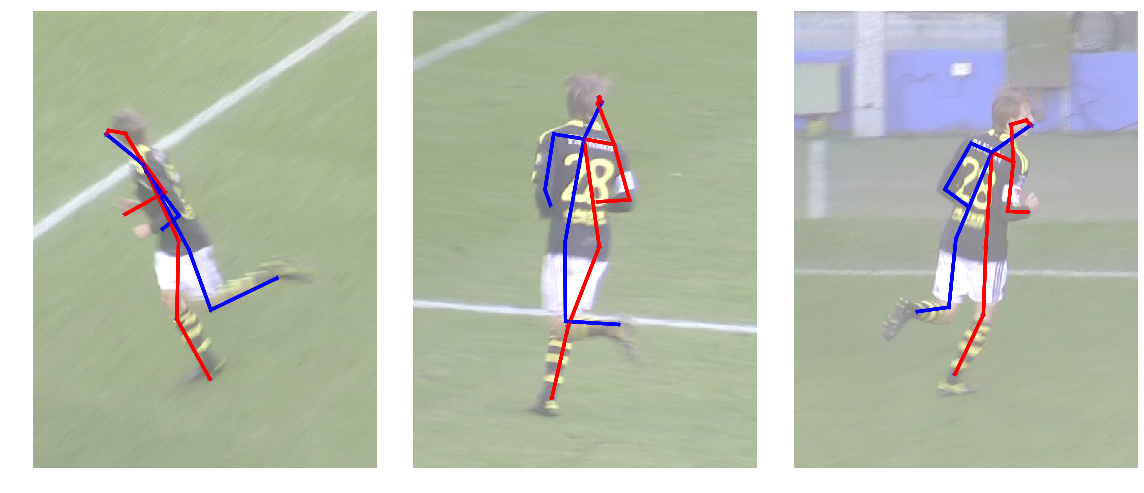

In [10]:
fig = plt.figure(figsize=(16,12))

print("FRAME", FRAME)
H = track.get_by_frame(FRAME)
if len(H) == 18:
    H = [H]
    
Humans = kth.transform3d_from_mscoco(H)

print(extract_best(pos3d, Humans, alpha=0.5))

colors = ['blue', 'red', 'green', 'teal']

for cid, cam in enumerate(calib):
    ax = fig.add_subplot(1, 3, 1+cid)
    ax.axis('off')
    im = Im[cid]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, hyp in enumerate(H):
        draw_mscoco_human(ax, hyp, cam, alpha=0.5,
                          color=colors[pid], lcolor='red', linewidth=3)
    
plt.tight_layout()
plt.show()

In [11]:
assert False

AssertionError: 

In [ ]:
    # R_ANKLE       0
    # R_KNEE        1
    # R_HIP         2
    # L_HIP         3
    # L_KNEE        4
    # L_ANKLE       5
    # R_WRIST       6
    # R_ELBOW       7
    # R_SHOULDER    8
    # L_SHOULDER    9
    # L_ELBOW       10
    # L_WRIST       11
    # BOTTOM_HEAD   12
    # TOP_HEAD      13
    

from mpl_toolkits.mplot3d import Axes3D

jid = 4  # 7 = hand left, 4 = hand right

HL = []

for t in range(0, 214):
    pose = track.get_by_frame(t)
    if pose is None or pose[jid] is None:
        HL.append(None)
    else:
        HL.append(pose[jid])
        
io = [0 if e is None else 1 for e in HL]

xy = np.array([(e[0], e[1], e[2]) for e in HL if e is not None])

umin = np.min(xy)
umax = np.max(xy)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([umin, umax])
ax.set_ylim([umin, umax])
ax.set_zlim([umin, umax])


# xy = xy[100:130]

ax.plot(xy[:, 0], xy[:, 1], xy[:, 2])

plt.show()

In [ ]:
p_gt = []
t_gt = []
p = []
t = []

jid = 10  # right hand
gt_jid = 0  # right foot

for frame in range(0, 214):
    
    gt = Pos3d[frame]
    p_gt.append(gt[gt_jid])
    t_gt.append(frame)
    
    pose = track.get_by_frame(frame)
    if pose is None or pose[jid] is None:
        continue
    p.append(pose[jid])
    t.append(frame)
    
p_gt = np.array(p_gt)
p = np.array(p)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)


print(p.shape)

dim = 2

ax.plot(t_gt, p_gt[:, dim])
ax.plot(t, p[:, dim])

plt.show()

In [ ]:
# fill the gaps with interpolations
from scipy.ndimage.filters import gaussian_filter1d
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
import numpy.linalg as la

t = []
p = []
for frame in range(0, 214):
    pose = track.get_by_frame(frame)
    if pose is None or pose[jid] is None:
        pts = []
        start_frame = max(0, frame - 5)
        end_frame = min(214, frame + 5)
        for _frame in range(start_frame, end_frame):
            _pose = track.get_by_frame(_frame)
            if _pose is None or _pose[jid] is None:
                continue
            pts.append(_pose[jid])
        assert len(pts) > 0
        pt = np.mean(pts, axis=0)
    else:
        pt = pose[jid]
        
    p.append(pt)
    t.append(frame)
p = np.array(p)

# gaussian blur
sigma = 1.8
#data = np.expand_dims(p[:, dim])
data = p[:, dim]

p_gaussian = gaussian_filter1d(data, sigma, mode='reflect')


# ES
es = SimpleExpSmoothing(data).fit(smoothing_level=0.9)
p_es = es.fittedvalues


fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

ax.plot(t_gt, p_gt[:, dim], label='gt')
ax.plot(t, p[:, dim], label='original signal')
ax.plot(t, p_gaussian, label='gaussian')
# ax.plot(t, p_es, label='exp smoothing')

def l2(gt, data):
    return la.norm(gt - data)

print('original\t', l2(p_gt[:, dim], p[:, dim]))
print('gaussian\t', l2(p_gt[:, dim], p_gaussian))
# print('expsmooth\t', l2(p_gt[:, dim], p_es))

plt.legend()
plt.show()

In [ ]:
def smoothing(track, sigma, interpolation_range=4):
    first_frame = track.frames[0]
    last_frame = track.last_seen()

    XYZ = []
    for frame in range(first_frame, last_frame):
        pose = track.get_by_frame(frame)
        if pose is None or pose[jid] is None:
            pts = []
            start_frame = max(first_frame, frame - 5)
            end_frame = min(last_frame, frame + 5)
            for _frame in range(start_frame, end_frame):
                _pose = track.get_by_frame(_frame)
                if _pose is None or _pose[jid] is None:
                    continue
                pts.append(_pose[jid])
            assert len(pts) > 0
            pt = np.mean(pts, axis=0)
        else:
            pt = pose[jid]
        XYZ.append(pt)
    
    XYZ = np.array(XYZ) * 1000
    XYZ_sm = np.empty_like(XYZ)
    for dim in range(0, 3):
        D = XYZ[:, dim]
        D = gaussian_filter1d(D, sigma, mode='reflect')
        XYZ_sm[:, dim] = D
    return XYZ_sm, XYZ
    
S = []
A = []
M = []
O = []

for sigma in np.linspace(1, 2, 10):
    Pred, Orig = smoothing(track, sigma)
    Gt = p_gt[0:213, ] * 1000
    
    l2 = la.norm(Pred - Gt, axis=1)
    l2_o = la.norm(Orig - Gt, axis=1)
#     print('sigma ' + str(sigma) + '\t')
#     print('\tmean ', np.mean(l2))
#     print('\tmax  ', np.max(l2))
#     print('\torig:', np.mean(l2_o))
    
    S.append(sigma)
    A.append(np.mean(l2))
    M.append(np.max(l2))
    O.append(np.mean(l2_o))

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)


ax.plot(S, A, label='mean')
ax.plot(S, M, label='max')
ax.plot(S, O, label='orignal')


plt.legend()
plt.show()

In [ ]:
X = Orig[:, 0]
X_ = Pred[:, 0]
X__ = Gt[:, 0]

print("g", Gt.shape)

t = range(len(X))

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

ax.plot(t, X, label='original')
ax.plot(t, X_, label='prediction')
ax.plot(t, X__, label='gt')

plt.legend()
plt.show()

In [ ]:
def check_dim(Orig, Gt, dim, sigma):
    D = Orig[:, dim]
    G = Gt[:, dim]
    F = gaussian_filter1d(D, sigma, mode='reflect')
    return np.mean((F - G)**2)
    
    
Sigma = np.linspace(0.5, 5, 20)
X = []
Y = []
Z = []

for s in Sigma:
    X.append(check_dim(Orig, Gt, 0, s))
    Y.append(check_dim(Orig, Gt, 1, s))
    Z.append(check_dim(Orig, Gt, 2, s))

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

ax.plot(Sigma, X, label='X')
ax.plot(Sigma, Y, label='Y')
ax.plot(Sigma, Z, label='Z')

plt.legend()
plt.show()